In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering

/home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering


In [3]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats

train = False

# Statistics of success mutants

In [4]:
success_save_path = 'data/round1/dry-lab/results/all_step_aa_seqs.csv_success.csv_uniq.csv'

df_succ_data = pd.read_csv(success_save_path)
len(df_succ_data), df_succ_data.columns

(42117,
 Index(['step', 'aa_seqs', 'weight', 'Activity', 'raw_Activity',
        'agent_likelihood', 'prior_likelihood', 'augmented_likelihood',
        'is_success', 'dist2BPN', 'seq_len'],
       dtype='object'))

## Mutantion numbers in each mutants

In [5]:
subtilisin_BPN = 'AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGGASMVPSETNPFQDNNSHGTHVAGTVAALNNSIGVLGVAPSASLYAVKVLGADGSGQYSWIINGIEWAIANNMDVINMSLGGPSGSAAL' \
    'KAAVDKAVASGVVVVAAAGNEGTSGSSSTVGYPGKYPSVIAVGAVDSSNQRASFSSVGPELDVMAPGVSIQSTLPGNKYGAYNGTSMASPHVAGAAALILSKHPNWTNTQVRSSLENTTTKLGDSFYYGKGLINVQAAAQ'

def get_mutations(aa_seq):
    muts = []
    for i in range(len(subtilisin_BPN)):
        if subtilisin_BPN[i] != aa_seq[i]:
            muts.append(f"{subtilisin_BPN[i]}{i+1}{aa_seq[i]}")
    return '/'.join(muts)

df_succ_data['mutations'] = [get_mutations(aa_seq) for aa_seq in df_succ_data.aa_seqs]
df_succ_data['n_muts'] = [len(muts.split('/')) if '/' in muts else 0 for muts in df_succ_data.mutations]
df_succ_data.n_muts.min(), df_succ_data.n_muts.max()

(0, 11)

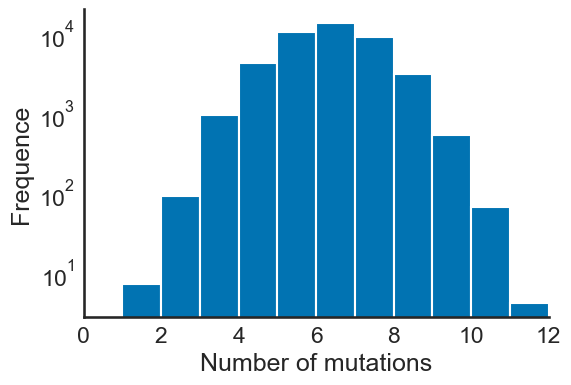

In [6]:
from utils import plot_style_utils
from matplotlib.ticker import MaxNLocator

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

bins = range(0, 13, 1)

df_succ_data[['mutations', 'dist2BPN']].groupby(['dist2BPN']).hist(ax=ax, bins=bins, color=plot_style_utils.CAT_PALETTE[0])
ax.grid(False)
ax.set_title('')
ax.set_xlabel('Number of mutations')
ax.set_ylabel('Frequence')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_yscale('log')
ax.set_xlim(0, 12)
plot_style_utils.save_for_pub(fig, path='figures/round1/mutant_n_mutations')

## Common mutations

In [7]:
from collections import Counter

def get_mut2count(df):
    mut2count = Counter([mut for muts in df.mutations for mut in muts.split('/')])
    dict_mut2count = {k: v for k, v in sorted(mut2count.items(), key=lambda item: item[1], reverse=True)}
    df_mut2count = pd.DataFrame({'mutation': list(dict_mut2count.keys()), 'counts': list(dict_mut2count.values())})
    df_mut2count = df_mut2count[df_mut2count.mutation != 'wild-type']

    df_mut2count['pos']  = [mut[1:-1] for mut in df_mut2count.mutation]  # for postion analysis

    print(df_mut2count.counts.min(), df_mut2count.counts.max(), df_mut2count.counts.median())
    return df_mut2count

df_mut2count = get_mut2count(df_succ_data)
len(df_mut2count), df_mut2count.columns

1 41805 582.0


(106, Index(['mutation', 'counts', 'pos'], dtype='object'))

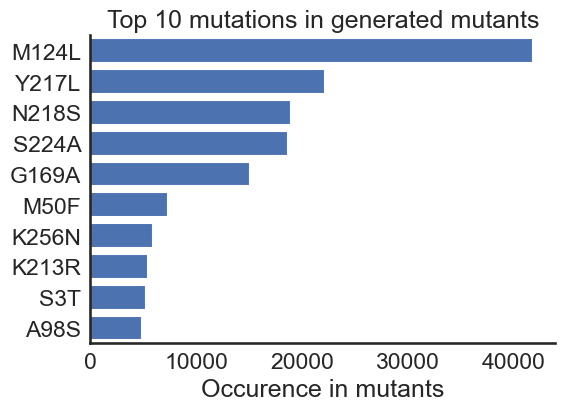

In [8]:
from utils import plot_style_utils

topn=10

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

df_topn_mutations = df_mut2count.nlargest(topn, 'counts')# .mutation

ax.barh(df_topn_mutations.mutation[::-1], df_topn_mutations.counts[::-1], )
ax.set_yticks(df_topn_mutations.mutation[::-1])
ax.set_yticklabels(df_topn_mutations.mutation[::-1])
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel('Occurence in mutants')
ax.set_title(f'Top {topn} mutations in generated mutants')
plot_style_utils.save_for_pub(fig, path=f'figures/round1/mutant_top_{topn}_mutations')